# Regression Deep Learning Model for Allstate Claims Severity Using TensorFlow Take 5
### David Lowe
### February 21, 2020

Template Credit: Adapted from a template made available by Dr. Jason Brownlee of Machine Learning Mastery. [https://machinelearningmastery.com/]

SUMMARY: The purpose of this project is to construct a predictive model using various machine learning algorithms and to document the end-to-end steps using a template. The Allstate Claims Severity dataset is a regression situation where we are trying to predict the value of a continuous variable.

INTRODUCTION: Allstate is interested in developing automated methods of predicting the cost, and hence severity, of claims. In this Kaggle challenge, the contestants were asked to create an algorithm which could accurately predicts claims severity. Each row in this dataset represents an insurance claim. The task is to predict the value for the 'loss' column. Variables prefaced with 'cat' are categorical, while those prefaced with 'cont' are continuous.

In iteration Take1, we constructed machine learning models using the original dataset and with minimum data preparation and no feature engineering. The XGBoost model serves as the baseline for the future iterations of modeling.

In iteration Take2, we tuned additional parameters of the XGBoost model and improved the MAE metric further.

In iteration Take3, we constructed several basic Multilayer Perceptron (MLP) models with one hidden layer. The basic MLP model serves as the baseline model as we build more complex MLP models in future iterations.

In iteration Take4, we constructed several Multilayer Perceptron (MLP) models with two hidden layers. We observed whether the additional hidden layer has a positive effect on MAE when compared to models that have just one hidden layer.

In this iteration, we will construct several Multilayer Perceptron (MLP) models with three hidden layers. We will observe whether the additional hidden layer has a positive effect on MAE when compared to models that have just one or two hidden layers.

ANALYSIS: In iteration Take1, the baseline performance of the machine learning algorithms achieved an average MAE of 1301. eXtreme Gradient Boosting (XGBoost) achieved the top MAE metric after the first round of modeling. After a series of tuning trials, XGBoost achieved an MAE metric of 1199. By using the optimized parameters, the XGBoost algorithm processed the test dataset with an MAE of 1204, which was in line with the MAE prediction from the training data.

In iteration Take2, the further-tuned eXtreme Gradient Boosting (XGBoost) model achieved an improved MAE metric of 1191 using the training data. By using the same optimized parameters, the XGBoost algorithm processed the test dataset with an MAE of 1195, which was in line with the MAE prediction from the training data.

In iteration Take3, the simple MLP model with 128 nodes achieved an MAE metric of 1193 on the test dataset after 50 epochs. The MLP model with 1024 nodes processed the same test dataset with an MAE of 1170 after the same number of epochs but with a much larger over-fitting.

In iteration Take4, the MLP model with 128/64 nodes and 0.25/0.25 Dropout ratios achieved an MAE metric of 1169 on the test dataset after 31 epochs. The MLP model with 256/128 nodes and 0.25/0.50 Dropout ratios also processed the same test dataset with an MAE of 1169 after 25 epochs.

In this iteration Take5, the MLP model with 512/128/64 nodes and 0.25/0.50/0.50 Dropout ratios achieved an MAE metric of 1164 on the test dataset after 16 epochs. The MLP model with 1024/512/256 nodes and 0.25/0.50/0.50 Dropout ratios also processed the same test dataset with an MAE of 1164 after 9 epochs.

CONCLUSION: For this iteration, the 512/128/64 nodes and 0.25/0.50/0.50 Dropout MLP model achieved good overall results using the training and testing datasets. It is a model that is simpler than the model that has 1024/512/256 nodes and 0.25/0.50/0.50 Dropout. For this dataset, we should consider experimenting with more MLP models.

Dataset Used: Allstate Claims Severity Data Set

Dataset ML Model: Regression with numerical and categorical attributes

Dataset Reference: https://www.kaggle.com/c/allstate-claims-severity/data

One potential source of performance benchmarks: https://www.kaggle.com/c/allstate-claims-severity/leaderboard

Any deep-learning modeling project genrally can be broken down into about seven major tasks:

0. Prepare Environment
1. Load Data
2. Define Model
3. Fit and Evaluate Model
4. Optimize Model
5. Finalize Model

# Section 0. Prepare Environment

In [1]:
# Retrieve GPU information
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Fri Feb 14 18:50:30 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.48.02    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P0    30W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [0]:
# Set the random seed number for reproducible results
seedNum = 888

In [0]:
# Load libraries and packages
import random
random.seed(seedNum)
import numpy as np
np.random.seed(seedNum)
import tensorflow as tf
tf.random.set_seed(seedNum)
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
import pandas as pd
import math
import os
import sys
import shutil
import urllib.request
import zipfile
import smtplib
import matplotlib.pyplot as plt
from datetime import datetime
from email.message import EmailMessage
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn import preprocessing

In [5]:
# Begin the timer for the script processing
startTimeScript = datetime.now()

# Set up the verbose flag to print detailed messages for debugging (setting to True will activate)
# verbose = True
# tf.debugging.set_log_device_placement(verbose)

# Set up the number of CPU cores available for multi-thread processing
n_jobs = -1
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

# Set up the flag to stop sending progress emails (setting to True will send status emails!)
notifyStatus = False

# Set the number of folds for cross validation
n_folds = 5

# Set the flag for splitting the dataset
splitDataset = True
splitPercentage = 0.25

# Set various default Keras modeling parameters
default_loss = 'mae'
default_optimizer = tf.optimizers.Adam(learning_rate=0.001)
default_kernel_init = tf.initializers.RandomNormal(seed=seedNum)
default_epoch = 50
default_batch = 64

Num GPUs Available:  1


In [0]:
# Set up the email notification function
def email_notify(msg_text):
    sender = os.environ.get('MAIL_SENDER')
    receiver = os.environ.get('MAIL_RECEIVER')
    gateway = os.environ.get('SMTP_GATEWAY')
    smtpuser = os.environ.get('SMTP_USERNAME')
    password = os.environ.get('SMTP_PASSWORD')
    if sender==None or receiver==None or gateway==None or smtpuser==None or password==None:
        sys.exit("Incomplete email setup info. Script Processing Aborted!!!")
    msg = EmailMessage()
    msg.set_content(msg_text)
    msg['Subject'] = 'Notification from Keras Regression Script'
    msg['From'] = sender
    msg['To'] = receiver
    server = smtplib.SMTP(gateway, 587)
    server.starttls()
    server.login(smtpuser, password)
    server.send_message(msg)
    server.quit()

In [0]:
# Reset the random number generators
def reset_random(x):
    random.seed(x)
    np.random.seed(x)
    tf.random.set_seed(x)

In [0]:
if (notifyStatus): email_notify("Phase 0 Prepare Environment completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

# Section 1. Load Data

In [0]:
if (notifyStatus): email_notify("Phase 1 Load Data has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## 1.a) Load Dataset

In [10]:
dataset_path = 'https://dainesanalytics.com/datasets/py-classification-allstate-claims-severity/train.csv'
Xy_original = pd.read_csv(dataset_path)

# Take a peek at the dataframe after the import
Xy_original.head(10)

,id,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cat10,cat11,cat12,cat13,cat14,cat15,cat16,cat17,cat18,cat19,cat20,cat21,cat22,cat23,cat24,cat25,cat26,cat27,cat28,cat29,cat30,cat31,cat32,cat33,cat34,cat35,cat36,cat37,cat38,cat39,...,cat92,cat93,cat94,cat95,cat96,cat97,cat98,cat99,cat100,cat101,cat102,cat103,cat104,cat105,cat106,cat107,cat108,cat109,cat110,cat111,cat112,cat113,cat114,cat115,cat116,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14,loss
0,1,A,B,A,B,A,A,A,A,B,A,B,A,A,A,A,A,A,A,A,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,...,A,D,B,C,E,A,C,T,B,G,A,A,I,E,G,J,G,BU,BC,C,AS,S,A,O,LB,0.726300,0.245921,0.187583,0.789639,0.310061,0.718367,0.335060,0.30260,0.67135,0.83510,0.569745,0.594646,0.822493,0.714843,2213.18
1,2,A,B,A,A,A,A,A,A,B,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,...,A,D,D,C,E,E,D,T,L,F,A,A,E,E,I,K,K,BI,CQ,A,AV,BM,A,O,DP,0.330514,0.737068,0.592681,0.614134,0.885834,0.438917,0.436585,0.60087,0.35127,0.43919,0.338312,0.366307,0.611431,0.304496,1283.60
2,5,A,B,A,A,B,A,A,A,B,B,B,B,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,B,A,A,A,...,A,D,D,C,E,E,A,D,L,O,A,B,E,F,H,F,A,AB,DK,A,C,AF,A,I,GK,0.261841,0.358319,0.484196,0.236924,0.397069,0.289648,0.315545,0.27320,0.26076,0.32446,0.381398,0.373424,0.195709,0.774425,3005.09
3,10,B,B,A,B,A,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,...,A,D,D,C,E,E,D,T,I,D,A,A,E,E,I,K,K,BI,CS,C,N,AE,A,O,DJ,0.321594,0.555782,0.527991,0.373816,0.422268,0.440945,0.391128,0.31796,0.32128,0.44467,0.327915,0.321570,0.605077,0.602642,939.85
4,11,A,B,A,B,A,A,A,A,B,B,A,B,A,A,A,A,A,A,A,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,...,H,D,B,D,E,E,A,P,F,J,A,A,D,E,K,G,B,H,C,C,Y,BM,A,K,CK,0.273204,0.159990,0.527991,0.473202,0.704268,0.178193,0.247408,0.24564,0.22089,0.21230,0.204687,0.202213,0.246011,0.432606,2763.85
5,13,A,B,A,A,A,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,...,A,D,D,D,E,C,A,P,J,D,A,A,E,E,H,F,B,BI,CS,A,AS,AE,A,K,DJ,0.546670,0.681761,0.634224,0.373816,0.302678,0.364464,0.401162,0.26847,0.46226,0.50556,0.366788,0.359249,0.345247,0.726792,5142.87
6,14,A,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,B,A,A,A,...,A,D,D,D,E,C,A,P,J,A,A,C,E,E,H,F,B,BI,DK,A,J,AF,A,K,DJ,0.471447,0.737068,0.613660,0.189137,0.295397,0.381515,0.363768,0.24564,0.40455,0.47225,0.334828,0.352251,0.342239,0.382931,1132.22
7,20,A,B,A,B,A,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,B,A,A,A,A,B,A,A,A,B,A,A,A,A,A,A,A,...,A,C,B,C,E,A,C,T,H,C,A,A,K,F,F,I,G,BI,EB,G,AH,Y,A,P,LO,0.826591,0.488789,0.263570,0.623770,0.473767,0.867021,0.583389,0.90267,0.84847,0.80218,0.644013,0.785706,0.859764,0.242416,3585.75
8,23,A,B,B,B,B,A,A,A,B,B,B,B,B,A,A,B,A,A,A,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,B,A,B,A,...,A,D,C,C,E,C,D,T,C,Q,A,C,H,F,G,M,K,BI,BC,C,K,AX,A,Q,IE,0.330514,0.555782,0.440642,0.473202,0.281143,0.628534,0.384099,0.61229,0.38249,0.51111,0.682315,0.669033,0.756454,0.361191,10280.20
9,24,A,B,A,A,B,B,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,B,A,B,B,...,H,D,B,C,E,A,C,T,F,D,A,F,K,H,G,J,G,BU,DW,A,U,S,J,O,LY,0.726300,0.358319,0.356819,0.802892,0.310061,0.713343,0.469223,0.30260,0.67135,0.83510,0.863052,0.879347,0.822493,0.294523,6184.59


In [11]:
Xy_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188318 entries, 0 to 188317
Columns: 132 entries, id to loss
dtypes: float64(15), int64(1), object(116)
memory usage: 189.7+ MB


In [12]:
Xy_original.describe()

,id,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14,loss
count,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000
mean,294135.982561,0.493861,0.507188,0.498918,0.491812,0.487428,0.490945,0.484970,0.486437,0.485506,0.498066,0.493511,0.493150,0.493138,0.495717,3037.337686
std,169336.084867,0.187640,0.207202,0.202105,0.211292,0.209027,0.205273,0.178450,0.199370,0.181660,0.185877,0.209737,0.209427,0.212777,0.222488,2904.086186
min,1.000000,0.000016,0.001149,0.002634,0.176921,0.281143,0.012683,0.069503,0.236880,0.000080,0.000000,0.035321,0.036232,0.000228,0.179722,0.670000
25%,147748.250000,0.346090,0.358319,0.336963,0.327354,0.281143,0.336105,0.350175,0.312800,0.358970,0.364580,0.310961,0.311661,0.315758,0.294610,1204.460000
50%,294539.500000,0.475784,0.555782,0.527991,0.452887,0.422268,0.440945,0.438285,0.441060,0.441450,0.461190,0.457203,0.462286,0.363547,0.407403,2115.570000
75%,440680.500000,0.623912,0.681761,0.634224,0.652072,0.643315,0.655021,0.591045,0.623580,0.566820,0.614590,0.678924,0.675759,0.689974,0.724623,3864.045000
max,587633.000000,0.984975,0.862654,0.944251,0.954297,0.983674,0.997162,1.000000,0.980200,0.995400,0.994980,0.998742,0.998484,0.988494,0.844848,121012.250000


In [13]:
print(Xy_original.isnull().sum())
print('Total number of NaN in the dataframe: ', Xy_original.isnull().sum().sum())

id        0
cat1      0
cat2      0
cat3      0
cat4      0
         ..
cont11    0
cont12    0
cont13    0
cont14    0
loss      0
Length: 132, dtype: int64
Total number of NaN in the dataframe:  0


## 1.b) Data Cleaning

In [14]:
# Standardize the class column to the name of targetVar if required
Xy_original = Xy_original.rename(columns={'loss': 'targetVar'})

# Dropping unnecessary feature(s)
Xy_original.drop(columns=['id'], inplace=True)

# Convert columns from one data type to another
categorical_cols = ["cat" + str(i) for i in range(1,117)]
Xy_original[categorical_cols] = Xy_original[categorical_cols].astype('category')

# Take a peek at the dataframe after the cleaning
Xy_original.head(10)

,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cat10,cat11,cat12,cat13,cat14,cat15,cat16,cat17,cat18,cat19,cat20,cat21,cat22,cat23,cat24,cat25,cat26,cat27,cat28,cat29,cat30,cat31,cat32,cat33,cat34,cat35,cat36,cat37,cat38,cat39,cat40,...,cat92,cat93,cat94,cat95,cat96,cat97,cat98,cat99,cat100,cat101,cat102,cat103,cat104,cat105,cat106,cat107,cat108,cat109,cat110,cat111,cat112,cat113,cat114,cat115,cat116,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14,targetVar
0,A,B,A,B,A,A,A,A,B,A,B,A,A,A,A,A,A,A,A,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,...,A,D,B,C,E,A,C,T,B,G,A,A,I,E,G,J,G,BU,BC,C,AS,S,A,O,LB,0.726300,0.245921,0.187583,0.789639,0.310061,0.718367,0.335060,0.30260,0.67135,0.83510,0.569745,0.594646,0.822493,0.714843,2213.18
1,A,B,A,A,A,A,A,A,B,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,...,A,D,D,C,E,E,D,T,L,F,A,A,E,E,I,K,K,BI,CQ,A,AV,BM,A,O,DP,0.330514,0.737068,0.592681,0.614134,0.885834,0.438917,0.436585,0.60087,0.35127,0.43919,0.338312,0.366307,0.611431,0.304496,1283.60
2,A,B,A,A,B,A,A,A,B,B,B,B,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,B,A,A,A,A,...,A,D,D,C,E,E,A,D,L,O,A,B,E,F,H,F,A,AB,DK,A,C,AF,A,I,GK,0.261841,0.358319,0.484196,0.236924,0.397069,0.289648,0.315545,0.27320,0.26076,0.32446,0.381398,0.373424,0.195709,0.774425,3005.09
3,B,B,A,B,A,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,...,A,D,D,C,E,E,D,T,I,D,A,A,E,E,I,K,K,BI,CS,C,N,AE,A,O,DJ,0.321594,0.555782,0.527991,0.373816,0.422268,0.440945,0.391128,0.31796,0.32128,0.44467,0.327915,0.321570,0.605077,0.602642,939.85
4,A,B,A,B,A,A,A,A,B,B,A,B,A,A,A,A,A,A,A,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,...,H,D,B,D,E,E,A,P,F,J,A,A,D,E,K,G,B,H,C,C,Y,BM,A,K,CK,0.273204,0.159990,0.527991,0.473202,0.704268,0.178193,0.247408,0.24564,0.22089,0.21230,0.204687,0.202213,0.246011,0.432606,2763.85
5,A,B,A,A,A,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,...,A,D,D,D,E,C,A,P,J,D,A,A,E,E,H,F,B,BI,CS,A,AS,AE,A,K,DJ,0.546670,0.681761,0.634224,0.373816,0.302678,0.364464,0.401162,0.26847,0.46226,0.50556,0.366788,0.359249,0.345247,0.726792,5142.87
6,A,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,B,A,A,A,A,...,A,D,D,D,E,C,A,P,J,A,A,C,E,E,H,F,B,BI,DK,A,J,AF,A,K,DJ,0.471447,0.737068,0.613660,0.189137,0.295397,0.381515,0.363768,0.24564,0.40455,0.47225,0.334828,0.352251,0.342239,0.382931,1132.22
7,A,B,A,B,A,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,B,A,A,A,A,B,A,A,A,B,A,A,A,A,A,A,A,A,...,A,C,B,C,E,A,C,T,H,C,A,A,K,F,F,I,G,BI,EB,G,AH,Y,A,P,LO,0.826591,0.488789,0.263570,0.623770,0.473767,0.867021,0.583389,0.90267,0.84847,0.80218,0.644013,0.785706,0.859764,0.242416,3585.75
8,A,B,B,B,B,A,A,A,B,B,B,B,B,A,A,B,A,A,A,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,B,A,B,A,A,...,A,D,C,C,E,C,D,T,C,Q,A,C,H,F,G,M,K,BI,BC,C,K,AX,A,Q,IE,0.330514,0.555782,0.440642,0.473202,0.281143,0.628534,0.384099,0.61229,0.38249,0.51111,0.682315,0.669033,0.756454,0.361191,10280.20
9,A,B,A,A,B,B,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,B,A,B,B,B,...,H,D,B,C,E,A,C,T,F,D,A,F,K,H,G,J,G,BU,DW,A,U,S,J,O,LY,0.726300,0.358319,0.356819,0.802892,0.310061,0.713343,0.469223,0.30260,0.67135,0.83510,0.863052,0.879347,0.822493,0.294523,6184.59


In [15]:
Xy_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188318 entries, 0 to 188317
Columns: 131 entries, cat1 to targetVar
dtypes: category(116), float64(15)
memory usage: 42.8 MB


In [16]:
Xy_original.describe()

,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14,targetVar
count,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000
mean,0.493861,0.507188,0.498918,0.491812,0.487428,0.490945,0.484970,0.486437,0.485506,0.498066,0.493511,0.493150,0.493138,0.495717,3037.337686
std,0.187640,0.207202,0.202105,0.211292,0.209027,0.205273,0.178450,0.199370,0.181660,0.185877,0.209737,0.209427,0.212777,0.222488,2904.086186
min,0.000016,0.001149,0.002634,0.176921,0.281143,0.012683,0.069503,0.236880,0.000080,0.000000,0.035321,0.036232,0.000228,0.179722,0.670000
25%,0.346090,0.358319,0.336963,0.327354,0.281143,0.336105,0.350175,0.312800,0.358970,0.364580,0.310961,0.311661,0.315758,0.294610,1204.460000
50%,0.475784,0.555782,0.527991,0.452887,0.422268,0.440945,0.438285,0.441060,0.441450,0.461190,0.457203,0.462286,0.363547,0.407403,2115.570000
75%,0.623912,0.681761,0.634224,0.652072,0.643315,0.655021,0.591045,0.623580,0.566820,0.614590,0.678924,0.675759,0.689974,0.724623,3864.045000
max,0.984975,0.862654,0.944251,0.954297,0.983674,0.997162,1.000000,0.980200,0.995400,0.994980,0.998742,0.998484,0.988494,0.844848,121012.250000


In [17]:
print(Xy_original.isnull().sum())
print('Total number of NaN in the dataframe: ', Xy_original.isnull().sum().sum())

cat1         0
cat2         0
cat3         0
cat4         0
cat5         0
            ..
cont11       0
cont12       0
cont13       0
cont14       0
targetVar    0
Length: 131, dtype: int64
Total number of NaN in the dataframe:  0


## 1.c) Feature Scaling and Pre-processing

In [0]:
# Use variable totCol to hold the number of columns in the dataframe
totCol = len(Xy_original.columns)

# Set up variable totAttr for the total number of attribute columns
totAttr = totCol-1

# targetCol variable indicates the column location of the target/class variable
# If the first column, set targetCol to 1. If the last column, set targetCol to totCol
# If (targetCol <> 1) and (targetCol <> totCol), be aware when slicing up the dataframes for visualization
targetCol = totCol

In [19]:
# We create attribute-only and target-only datasets (X_original and y_original)
# for various visualization and cleaning/transformation operations

if targetCol == totCol:
    X_original = Xy_original.iloc[:,0:totAttr]
    y_original = Xy_original.iloc[:,totAttr]
else:
    X_original = Xy_original.iloc[:,1:totCol]
    y_original = Xy_original.iloc[:,0]

print("Xy_original.shape: {} X_original.shape: {} y_original.shape: {}".format(Xy_original.shape, X_original.shape, y_original.shape))

Xy_original.shape: (188318, 131) X_original.shape: (188318, 130) y_original.shape: (188318,)


## 1.d) Splitting Data into Training and Test Sets

In [20]:
# Perform one-hot-encoding before splitting into trainig and test
X_original = pd.get_dummies(X_original)
print(X_original.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188318 entries, 0 to 188317
Columns: 1153 entries, cont1 to cat116_Y
dtypes: float64(14), uint8(1139)
memory usage: 224.7 MB
None


In [21]:
X_encoded = X_original.to_numpy()
y_encoded = y_original.to_numpy()
if (splitDataset):
    X_train, X_test, y_train, y_test = train_test_split(X_encoded, y_encoded, test_size=splitPercentage, random_state=seedNum)
else:
    X_train, y_train = X_encoded, y_encoded
    X_test, y_test = X_encoded, y_encoded
print("X_train.shape: {} X_train.type: {}".format(X_train.shape, type(X_train)))
print("y_train.shape: {} y_train.type: {}".format(y_train.shape, type(y_train)))
print("X_test.shape: {} X_test.type: {}".format(X_test.shape, type(X_test)))
print("y_test.shape: {} y_test.type: {}".format(y_test.shape, type(y_test)))

X_train.shape: (141238, 1153) X_train.type: <class 'numpy.ndarray'>
y_train.shape: (141238,) y_train.type: <class 'numpy.ndarray'>
X_test.shape: (47080, 1153) X_test.type: <class 'numpy.ndarray'>
y_test.shape: (47080,) y_test.type: <class 'numpy.ndarray'>


In [0]:
if (notifyStatus): email_notify("Phase 1 Load Data completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

# Section 2. Define Baseline Model Architecture

In [0]:
if (notifyStatus): email_notify("Phase 2 Define Model has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [0]:
# Define MLP model #1_a
def create_model_1_a():
    default_model = Sequential()
    default_model.add(Dense(128, input_shape=(X_train.shape[1],), activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dense(64, activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dense(32, activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dense(1, kernel_initializer=default_kernel_init))
    default_model.compile(loss=default_loss, optimizer=default_optimizer)
    return default_model

In [0]:
# Define MLP model #1_b
def create_model_1_b():
    default_model = Sequential()
    default_model.add(Dense(128, input_shape=(X_train.shape[1],), activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dropout(0.25))
    default_model.add(Dense(64, activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dropout(0.25))
    default_model.add(Dense(32, activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dropout(0.25))
    default_model.add(Dense(1, kernel_initializer=default_kernel_init))
    default_model.compile(loss=default_loss, optimizer=default_optimizer)
    return default_model

In [0]:
# Define MLP model #1_c
def create_model_1_c():
    default_model = Sequential()
    default_model.add(Dense(128, input_shape=(X_train.shape[1],), activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dropout(0.25))
    default_model.add(Dense(64, activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dropout(0.25))
    default_model.add(Dense(32, activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dropout(0.5))
    default_model.add(Dense(1, kernel_initializer=default_kernel_init))
    default_model.compile(loss=default_loss, optimizer=default_optimizer)
    return default_model

In [0]:
# Define MLP model #1_d
def create_model_1_d():
    default_model = Sequential()
    default_model.add(Dense(128, input_shape=(X_train.shape[1],), activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dropout(0.25))
    default_model.add(Dense(64, activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dropout(0.5))
    default_model.add(Dense(32, activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dropout(0.5))
    default_model.add(Dense(1, kernel_initializer=default_kernel_init))
    default_model.compile(loss=default_loss, optimizer=default_optimizer)
    return default_model

In [0]:
# Define MLP model #1_e
def create_model_1_e():
    default_model = Sequential()
    default_model.add(Dense(128, input_shape=(X_train.shape[1],), activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dropout(0.5))
    default_model.add(Dense(64, activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dropout(0.5))
    default_model.add(Dense(32, activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dropout(0.5))
    default_model.add(Dense(1, kernel_initializer=default_kernel_init))
    default_model.compile(loss=default_loss, optimizer=default_optimizer)
    return default_model

In [0]:
if (notifyStatus): email_notify("Phase 2 Define Model completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

# Section 3. Fit and Evaluate Model Set #1

In [0]:
if (notifyStatus): email_notify("Phase 3 Fit and Evaluate Model has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

Train on 141238 samples, validate on 47080 samples
Epoch 1/50
141238/141238 [==============================] - 12s 84us/sample - loss: 1367.5643 - val_loss: 1219.4764
Epoch 2/50
141238/141238 [==============================] - 11s 81us/sample - loss: 1197.2588 - val_loss: 1205.4048
Epoch 3/50
141238/141238 [==============================] - 11s 80us/sample - loss: 1186.9106 - val_loss: 1200.8223
Epoch 4/50
141238/141238 [==============================] - 11s 81us/sample - loss: 1180.9732 - val_loss: 1196.8925
Epoch 5/50
141238/141238 [==============================] - 12s 82us/sample - loss: 1176.5186 - val_loss: 1193.0161
Epoch 6/50
141238/141238 [==============================] - 11s 81us/sample - loss: 1171.0884 - val_loss: 1191.9871
Epoch 7/50
141238/141238 [==============================] - 11s 77us/sample - loss: 1166.0674 - val_loss: 1197.6868
Epoch 8/50
141238/141238 [==============================] - 11s 77us/sample - loss: 1160.7721 - val_loss: 1184.3314
Epoch 9/50
141238/141

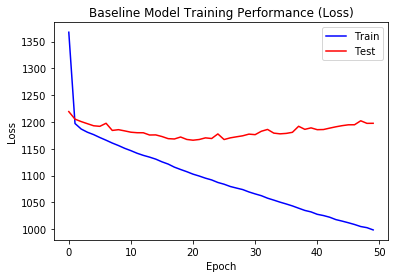

In [31]:
startTimeModule = datetime.now()

# Initialize the baseline model
reset_random(seedNum)
baseline_model_1_a = create_model_1_a()
baseline_hist_1_a = baseline_model_1_a.fit(X_train, y_train, epochs=default_epoch, batch_size=default_batch, 
                                       validation_data=(X_test, y_test), verbose=1)
print('Total time for performing cross-validation of the default model:', (datetime.now() - startTimeModule))

# Summarize model training hisotry for accuracy and loss
plt.plot(baseline_hist_1_a.history['loss'], color='blue', label='MAE - Training')
plt.plot(baseline_hist_1_a.history['val_loss'], color='red', label='MAE - Test')
plt.title('Baseline Model Training Performance (Loss)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

Train on 141238 samples, validate on 47080 samples
Epoch 1/50
141238/141238 [==============================] - 13s 91us/sample - loss: 1352.2783 - val_loss: 1217.8792
Epoch 2/50
141238/141238 [==============================] - 12s 82us/sample - loss: 1277.4149 - val_loss: 1210.5654
Epoch 3/50
141238/141238 [==============================] - 12s 84us/sample - loss: 1263.8181 - val_loss: 1204.9669
Epoch 4/50
141238/141238 [==============================] - 12s 82us/sample - loss: 1262.0382 - val_loss: 1198.3526
Epoch 5/50
141238/141238 [==============================] - 12s 83us/sample - loss: 1256.8733 - val_loss: 1198.1439
Epoch 6/50
141238/141238 [==============================] - 12s 82us/sample - loss: 1254.3312 - val_loss: 1195.2931
Epoch 7/50
141238/141238 [==============================] - 12s 84us/sample - loss: 1249.1268 - val_loss: 1192.2159
Epoch 8/50
141238/141238 [==============================] - 12s 81us/sample - loss: 1245.1927 - val_loss: 1193.3315
Epoch 9/50
141238/141

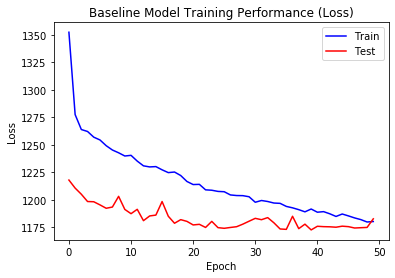

In [32]:
startTimeModule = datetime.now()

# Initialize the baseline model
reset_random(seedNum)
baseline_model_1_b = create_model_1_b()
baseline_hist_1_b = baseline_model_1_b.fit(X_train, y_train, epochs=default_epoch, batch_size=default_batch, 
                                       validation_data=(X_test, y_test), verbose=1)
print('Total time for performing cross-validation of the default model:', (datetime.now() - startTimeModule))

# Summarize model training hisotry for accuracy and loss
plt.plot(baseline_hist_1_b.history['loss'], color='blue', label='MAE - Training')
plt.plot(baseline_hist_1_b.history['val_loss'], color='red', label='MAE - Test')
plt.title('Baseline Model Training Performance (Loss)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

Train on 141238 samples, validate on 47080 samples
Epoch 1/50
141238/141238 [==============================] - 12s 88us/sample - loss: 1435.9249 - val_loss: 1224.0489
Epoch 2/50
141238/141238 [==============================] - 12s 82us/sample - loss: 1361.8890 - val_loss: 1213.8143
Epoch 3/50
141238/141238 [==============================] - 12s 85us/sample - loss: 1349.6369 - val_loss: 1215.8539
Epoch 4/50
141238/141238 [==============================] - 12s 88us/sample - loss: 1349.1170 - val_loss: 1202.7914
Epoch 5/50
141238/141238 [==============================] - 12s 85us/sample - loss: 1344.5058 - val_loss: 1205.6518
Epoch 6/50
141238/141238 [==============================] - 12s 84us/sample - loss: 1344.3733 - val_loss: 1203.2971
Epoch 7/50
141238/141238 [==============================] - 12s 82us/sample - loss: 1336.6581 - val_loss: 1195.4806
Epoch 8/50
141238/141238 [==============================] - 12s 85us/sample - loss: 1335.8335 - val_loss: 1201.9978
Epoch 9/50
141238/141

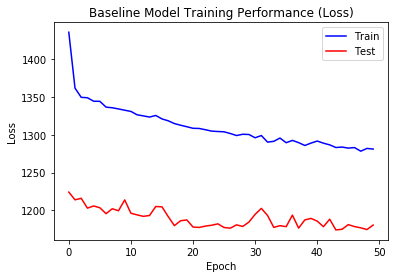

In [33]:
startTimeModule = datetime.now()

# Initialize the baseline model
reset_random(seedNum)
baseline_model_1_c = create_model_1_c()
baseline_hist_1_c = baseline_model_1_c.fit(X_train, y_train, epochs=default_epoch, batch_size=default_batch, 
                                       validation_data=(X_test, y_test), verbose=1)
print('Total time for performing cross-validation of the default model:', (datetime.now() - startTimeModule))

# Summarize model training hisotry for accuracy and loss
plt.plot(baseline_hist_1_c.history['loss'], color='blue', label='MAE - Training')
plt.plot(baseline_hist_1_c.history['val_loss'], color='red', label='MAE - Test')
plt.title('Baseline Model Training Performance (Loss)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

Train on 141238 samples, validate on 47080 samples
Epoch 1/50
141238/141238 [==============================] - 12s 88us/sample - loss: 1441.8930 - val_loss: 1221.6161
Epoch 2/50
141238/141238 [==============================] - 11s 78us/sample - loss: 1364.0499 - val_loss: 1214.8254
Epoch 3/50
141238/141238 [==============================] - 11s 77us/sample - loss: 1354.4366 - val_loss: 1211.1178
Epoch 4/50
141238/141238 [==============================] - 12s 83us/sample - loss: 1353.2880 - val_loss: 1201.7449
Epoch 5/50
141238/141238 [==============================] - 11s 81us/sample - loss: 1346.6435 - val_loss: 1201.8164
Epoch 6/50
141238/141238 [==============================] - 12s 82us/sample - loss: 1348.1536 - val_loss: 1204.8512
Epoch 7/50
141238/141238 [==============================] - 12s 82us/sample - loss: 1341.0462 - val_loss: 1196.3683
Epoch 8/50
141238/141238 [==============================] - 11s 81us/sample - loss: 1338.9274 - val_loss: 1208.0920
Epoch 9/50
141238/141

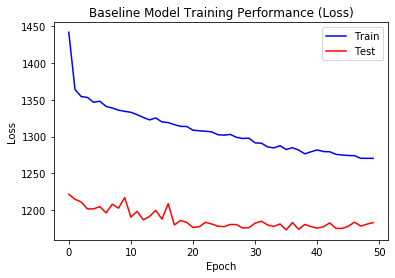

In [34]:
startTimeModule = datetime.now()

# Initialize the baseline model
reset_random(seedNum)
baseline_model_1_d = create_model_1_d()
baseline_hist_1_d = baseline_model_1_d.fit(X_train, y_train, epochs=default_epoch, batch_size=default_batch, 
                                       validation_data=(X_test, y_test), verbose=1)
print('Total time for performing cross-validation of the default model:', (datetime.now() - startTimeModule))

# Summarize model training hisotry for accuracy and loss
plt.plot(baseline_hist_1_d.history['loss'], color='blue', label='MAE - Training')
plt.plot(baseline_hist_1_d.history['val_loss'], color='red', label='MAE - Test')
plt.title('Baseline Model Training Performance (Loss)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

Train on 141238 samples, validate on 47080 samples
Epoch 1/50
141238/141238 [==============================] - 12s 85us/sample - loss: 1474.3096 - val_loss: 1230.1558
Epoch 2/50
141238/141238 [==============================] - 12s 82us/sample - loss: 1395.6448 - val_loss: 1222.3441
Epoch 3/50
141238/141238 [==============================] - 11s 80us/sample - loss: 1387.2789 - val_loss: 1214.5219
Epoch 4/50
141238/141238 [==============================] - 12s 81us/sample - loss: 1383.9322 - val_loss: 1207.6044
Epoch 5/50
141238/141238 [==============================] - 12s 82us/sample - loss: 1378.3663 - val_loss: 1207.1485
Epoch 6/50
141238/141238 [==============================] - 11s 81us/sample - loss: 1377.2016 - val_loss: 1208.1394
Epoch 7/50
141238/141238 [==============================] - 12s 85us/sample - loss: 1370.3525 - val_loss: 1203.0031
Epoch 8/50
141238/141238 [==============================] - 11s 80us/sample - loss: 1367.8476 - val_loss: 1210.5541
Epoch 9/50
141238/141

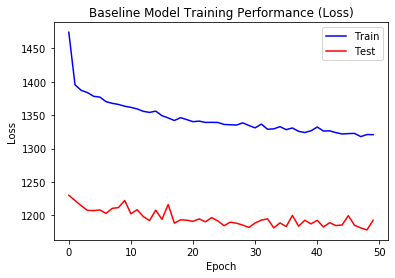

In [35]:
startTimeModule = datetime.now()

# Initialize the baseline model
reset_random(seedNum)
baseline_model_1_e = create_model_1_e()
baseline_hist_1_e = baseline_model_1_e.fit(X_train, y_train, epochs=default_epoch, batch_size=default_batch, 
                                       validation_data=(X_test, y_test), verbose=1)
print('Total time for performing cross-validation of the default model:', (datetime.now() - startTimeModule))

# Summarize model training hisotry for accuracy and loss
plt.plot(baseline_hist_1_e.history['loss'], color='blue', label='MAE - Training')
plt.plot(baseline_hist_1_e.history['val_loss'], color='red', label='MAE - Test')
plt.title('Baseline Model Training Performance (Loss)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

In [0]:
if (notifyStatus): email_notify("Phase 3 Fit and Evaluate Model completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

# Section 4. Fit and Evaluate Model Set #2

In [0]:
if (notifyStatus): email_notify("Phase 4 Fit and Evaluate Model Set #2 has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [0]:
# Define MLP model #2_a
def create_model_2_a():
    default_model = Sequential()
    default_model.add(Dense(256, input_shape=(X_train.shape[1],), activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dense(128, activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dense(64, activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dense(1, kernel_initializer=default_kernel_init))
    default_model.compile(loss=default_loss, optimizer=default_optimizer)
    return default_model

In [0]:
# Define MLP model #2_b
def create_model_2_b():
    default_model = Sequential()
    default_model.add(Dense(256, input_shape=(X_train.shape[1],), activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dropout(0.25))
    default_model.add(Dense(128, activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dropout(0.25))
    default_model.add(Dense(64, activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dropout(0.25))
    default_model.add(Dense(1, kernel_initializer=default_kernel_init))
    default_model.compile(loss=default_loss, optimizer=default_optimizer)
    return default_model

In [0]:
# Define MLP model #2_c
def create_model_2_c():
    default_model = Sequential()
    default_model.add(Dense(256, input_shape=(X_train.shape[1],), activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dropout(0.25))
    default_model.add(Dense(128, activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dropout(0.25))
    default_model.add(Dense(64, activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dropout(0.5))
    default_model.add(Dense(1, kernel_initializer=default_kernel_init))
    default_model.compile(loss=default_loss, optimizer=default_optimizer)
    return default_model

In [0]:
# Define MLP model #2_d
def create_model_2_d():
    default_model = Sequential()
    default_model.add(Dense(256, input_shape=(X_train.shape[1],), activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dropout(0.25))
    default_model.add(Dense(128, activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dropout(0.5))
    default_model.add(Dense(64, activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dropout(0.5))
    default_model.add(Dense(1, kernel_initializer=default_kernel_init))
    default_model.compile(loss=default_loss, optimizer=default_optimizer)
    return default_model

In [0]:
# Define MLP model #2_e
def create_model_2_e():
    default_model = Sequential()
    default_model.add(Dense(256, input_shape=(X_train.shape[1],), activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dropout(0.5))
    default_model.add(Dense(128, activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dropout(0.5))
    default_model.add(Dense(64, activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dropout(0.5))
    default_model.add(Dense(1, kernel_initializer=default_kernel_init))
    default_model.compile(loss=default_loss, optimizer=default_optimizer)
    return default_model

Train on 141238 samples, validate on 47080 samples
Epoch 1/50
141238/141238 [==============================] - 12s 84us/sample - loss: 1245.2217 - val_loss: 1205.8113
Epoch 2/50
141238/141238 [==============================] - 11s 79us/sample - loss: 1187.5515 - val_loss: 1198.5496
Epoch 3/50
141238/141238 [==============================] - 11s 81us/sample - loss: 1178.0092 - val_loss: 1194.8608
Epoch 4/50
141238/141238 [==============================] - 11s 81us/sample - loss: 1166.3294 - val_loss: 1185.6919
Epoch 5/50
141238/141238 [==============================] - 11s 79us/sample - loss: 1157.0565 - val_loss: 1176.1978
Epoch 6/50
141238/141238 [==============================] - 11s 79us/sample - loss: 1148.2619 - val_loss: 1172.1212
Epoch 7/50
141238/141238 [==============================] - 11s 81us/sample - loss: 1140.7607 - val_loss: 1168.3744
Epoch 8/50
141238/141238 [==============================] - 12s 82us/sample - loss: 1134.6812 - val_loss: 1174.2005
Epoch 9/50
141238/141

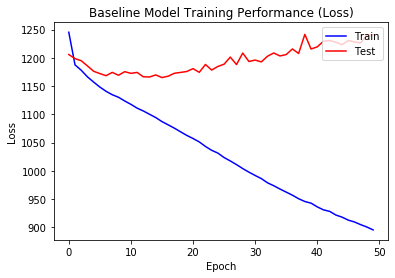

In [43]:
startTimeModule = datetime.now()

# Initialize the baseline model
reset_random(seedNum)
baseline_model_2_a = create_model_2_a()
baseline_hist_2_a = baseline_model_2_a.fit(X_train, y_train, epochs=default_epoch, batch_size=default_batch, 
                                       validation_data=(X_test, y_test), verbose=1)
print('Total time for performing cross-validation of the default model:', (datetime.now() - startTimeModule))

# Summarize model training hisotry for accuracy and loss
plt.plot(baseline_hist_2_a.history['loss'], color='blue', label='MAE - Training')
plt.plot(baseline_hist_2_a.history['val_loss'], color='red', label='MAE - Test')
plt.title('Baseline Model Training Performance (Loss)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

Train on 141238 samples, validate on 47080 samples
Epoch 1/50
141238/141238 [==============================] - 12s 87us/sample - loss: 1284.8112 - val_loss: 1210.5616
Epoch 2/50
141238/141238 [==============================] - 11s 81us/sample - loss: 1225.3180 - val_loss: 1201.9631
Epoch 3/50
141238/141238 [==============================] - 12s 83us/sample - loss: 1220.5986 - val_loss: 1196.5017
Epoch 4/50
141238/141238 [==============================] - 12s 81us/sample - loss: 1213.0840 - val_loss: 1191.3369
Epoch 5/50
141238/141238 [==============================] - 12s 82us/sample - loss: 1207.8450 - val_loss: 1186.1814
Epoch 6/50
141238/141238 [==============================] - 12s 85us/sample - loss: 1198.4600 - val_loss: 1183.7656
Epoch 7/50
141238/141238 [==============================] - 12s 83us/sample - loss: 1197.6560 - val_loss: 1181.6175
Epoch 8/50
141238/141238 [==============================] - 12s 82us/sample - loss: 1191.7296 - val_loss: 1181.1240
Epoch 9/50
141238/141

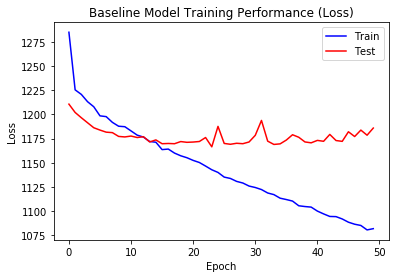

In [44]:
startTimeModule = datetime.now()

# Initialize the baseline model
reset_random(seedNum)
baseline_model_2_b = create_model_2_b()
baseline_hist_2_b = baseline_model_2_b.fit(X_train, y_train, epochs=default_epoch, batch_size=default_batch, 
                                       validation_data=(X_test, y_test), verbose=1)
print('Total time for performing cross-validation of the default model:', (datetime.now() - startTimeModule))

# Summarize model training hisotry for accuracy and loss
plt.plot(baseline_hist_2_b.history['loss'], color='blue', label='MAE - Training')
plt.plot(baseline_hist_2_b.history['val_loss'], color='red', label='MAE - Test')
plt.title('Baseline Model Training Performance (Loss)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

Train on 141238 samples, validate on 47080 samples
Epoch 1/50
141238/141238 [==============================] - 12s 86us/sample - loss: 1321.1134 - val_loss: 1212.0335
Epoch 2/50
141238/141238 [==============================] - 11s 80us/sample - loss: 1264.9125 - val_loss: 1206.6518
Epoch 3/50
141238/141238 [==============================] - 12s 84us/sample - loss: 1260.0594 - val_loss: 1199.6132
Epoch 4/50
141238/141238 [==============================] - 12s 83us/sample - loss: 1251.8559 - val_loss: 1194.5787
Epoch 5/50
141238/141238 [==============================] - 11s 80us/sample - loss: 1247.4074 - val_loss: 1187.8168
Epoch 6/50
141238/141238 [==============================] - 12s 82us/sample - loss: 1240.4844 - val_loss: 1184.8415
Epoch 7/50
141238/141238 [==============================] - 11s 81us/sample - loss: 1237.8988 - val_loss: 1182.3212
Epoch 8/50
141238/141238 [==============================] - 12s 82us/sample - loss: 1233.4946 - val_loss: 1178.8793
Epoch 9/50
141238/141

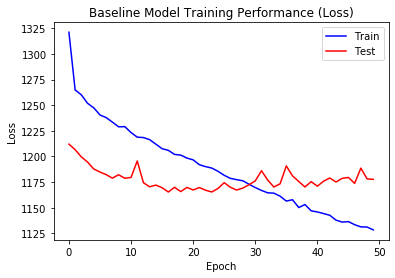

In [45]:
startTimeModule = datetime.now()

# Initialize the baseline model
reset_random(seedNum)
baseline_model_2_c = create_model_2_c()
baseline_hist_2_c = baseline_model_2_c.fit(X_train, y_train, epochs=default_epoch, batch_size=default_batch, 
                                       validation_data=(X_test, y_test), verbose=1)
print('Total time for performing cross-validation of the default model:', (datetime.now() - startTimeModule))

# Summarize model training hisotry for accuracy and loss
plt.plot(baseline_hist_2_c.history['loss'], color='blue', label='MAE - Training')
plt.plot(baseline_hist_2_c.history['val_loss'], color='red', label='MAE - Test')
plt.title('Baseline Model Training Performance (Loss)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

Train on 141238 samples, validate on 47080 samples
Epoch 1/50
141238/141238 [==============================] - 13s 89us/sample - loss: 1335.9612 - val_loss: 1213.1797
Epoch 2/50
141238/141238 [==============================] - 11s 81us/sample - loss: 1280.0767 - val_loss: 1201.7764
Epoch 3/50
141238/141238 [==============================] - 11s 81us/sample - loss: 1275.7308 - val_loss: 1201.9818
Epoch 4/50
141238/141238 [==============================] - 12s 84us/sample - loss: 1267.7057 - val_loss: 1205.1917
Epoch 5/50
141238/141238 [==============================] - 11s 81us/sample - loss: 1263.4600 - val_loss: 1190.1666
Epoch 6/50
141238/141238 [==============================] - 12s 83us/sample - loss: 1256.5228 - val_loss: 1185.5262
Epoch 7/50
141238/141238 [==============================] - 12s 82us/sample - loss: 1253.8565 - val_loss: 1183.8022
Epoch 8/50
141238/141238 [==============================] - 12s 85us/sample - loss: 1248.3381 - val_loss: 1180.4567
Epoch 9/50
141238/141

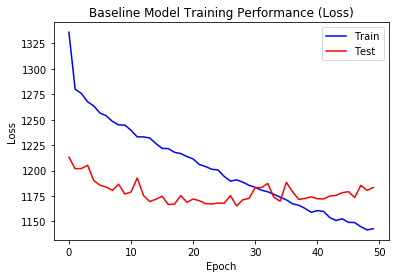

In [46]:
startTimeModule = datetime.now()

# Initialize the baseline model
reset_random(seedNum)
baseline_model_2_d = create_model_2_d()
baseline_hist_2_d = baseline_model_2_d.fit(X_train, y_train, epochs=default_epoch, batch_size=default_batch, 
                                       validation_data=(X_test, y_test), verbose=1)
print('Total time for performing cross-validation of the default model:', (datetime.now() - startTimeModule))

# Summarize model training hisotry for accuracy and loss
plt.plot(baseline_hist_2_d.history['loss'], color='blue', label='MAE - Training')
plt.plot(baseline_hist_2_d.history['val_loss'], color='red', label='MAE - Test')
plt.title('Baseline Model Training Performance (Loss)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

Train on 141238 samples, validate on 47080 samples
Epoch 1/50
141238/141238 [==============================] - 12s 87us/sample - loss: 1347.8748 - val_loss: 1222.1259
Epoch 2/50
141238/141238 [==============================] - 12s 82us/sample - loss: 1290.6727 - val_loss: 1207.0673
Epoch 3/50
141238/141238 [==============================] - 12s 83us/sample - loss: 1288.4489 - val_loss: 1203.1963
Epoch 4/50
141238/141238 [==============================] - 12s 82us/sample - loss: 1280.2342 - val_loss: 1201.3343
Epoch 5/50
141238/141238 [==============================] - 12s 87us/sample - loss: 1275.1477 - val_loss: 1192.8490
Epoch 6/50
141238/141238 [==============================] - 12s 82us/sample - loss: 1271.4338 - val_loss: 1191.7753
Epoch 7/50
141238/141238 [==============================] - 12s 82us/sample - loss: 1269.7943 - val_loss: 1188.3579
Epoch 8/50
141238/141238 [==============================] - 12s 82us/sample - loss: 1264.4589 - val_loss: 1189.8813
Epoch 9/50
141238/141

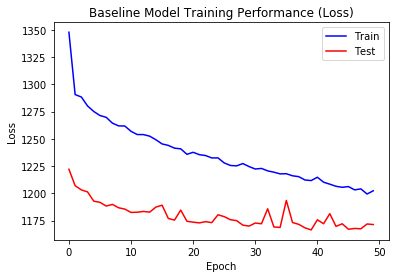

In [47]:
startTimeModule = datetime.now()

# Initialize the baseline model
reset_random(seedNum)
baseline_model_2_e = create_model_2_e()
baseline_hist_2_e = baseline_model_2_e.fit(X_train, y_train, epochs=default_epoch, batch_size=default_batch, 
                                       validation_data=(X_test, y_test), verbose=1)
print('Total time for performing cross-validation of the default model:', (datetime.now() - startTimeModule))

# Summarize model training hisotry for accuracy and loss
plt.plot(baseline_hist_2_e.history['loss'], color='blue', label='MAE - Training')
plt.plot(baseline_hist_2_e.history['val_loss'], color='red', label='MAE - Test')
plt.title('Baseline Model Training Performance (Loss)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

In [0]:
if (notifyStatus): email_notify("Phase 4 Fit and Evaluate Model Set #2! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

# Section 5. Fit and Evaluate Model Set #3

In [0]:
if (notifyStatus): email_notify("Phase 5 Fit and Evaluate Model Set #3 has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [0]:
# Define MLP model #3_a
def create_model_3_a():
    default_model = Sequential()
    default_model.add(Dense(512, input_shape=(X_train.shape[1],), activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dense(256, activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dense(128, activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dense(1, kernel_initializer=default_kernel_init))
    default_model.compile(loss=default_loss, optimizer=default_optimizer)
    return default_model

In [0]:
# Define MLP model #3_b
def create_model_3_b():
    default_model = Sequential()
    default_model.add(Dense(512, input_shape=(X_train.shape[1],), activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dropout(0.25))
    default_model.add(Dense(256, activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dropout(0.25))
    default_model.add(Dense(128, activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dropout(0.25))
    default_model.add(Dense(1, kernel_initializer=default_kernel_init))
    default_model.compile(loss=default_loss, optimizer=default_optimizer)
    return default_model

In [0]:
# Define MLP model #3_c
def create_model_3_c():
    default_model = Sequential()
    default_model.add(Dense(512, input_shape=(X_train.shape[1],), activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dropout(0.25))
    default_model.add(Dense(256, activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dropout(0.25))
    default_model.add(Dense(128, activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dropout(0.5))
    default_model.add(Dense(1, kernel_initializer=default_kernel_init))
    default_model.compile(loss=default_loss, optimizer=default_optimizer)
    return default_model

In [0]:
# Define MLP model #3_d
def create_model_3_d():
    default_model = Sequential()
    default_model.add(Dense(512, input_shape=(X_train.shape[1],), activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dropout(0.25))
    default_model.add(Dense(256, activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dropout(0.5))
    default_model.add(Dense(128, activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dropout(0.5))
    default_model.add(Dense(1, kernel_initializer=default_kernel_init))
    default_model.compile(loss=default_loss, optimizer=default_optimizer)
    return default_model

In [0]:
# Define MLP model #3_e
def create_model_3_e():
    default_model = Sequential()
    default_model.add(Dense(512, input_shape=(X_train.shape[1],), activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dropout(0.5))
    default_model.add(Dense(256, activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dropout(0.5))
    default_model.add(Dense(128, activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dropout(0.5))
    default_model.add(Dense(1, kernel_initializer=default_kernel_init))
    default_model.compile(loss=default_loss, optimizer=default_optimizer)
    return default_model

Train on 141238 samples, validate on 47080 samples
Epoch 1/50
141238/141238 [==============================] - 11s 78us/sample - loss: 1231.0468 - val_loss: 1198.9198
Epoch 2/50
141238/141238 [==============================] - 11s 77us/sample - loss: 1176.2292 - val_loss: 1183.4624
Epoch 3/50
141238/141238 [==============================] - 11s 79us/sample - loss: 1163.7306 - val_loss: 1192.9227
Epoch 4/50
141238/141238 [==============================] - 11s 76us/sample - loss: 1153.6507 - val_loss: 1190.8249
Epoch 5/50
141238/141238 [==============================] - 11s 78us/sample - loss: 1145.5003 - val_loss: 1169.4081
Epoch 6/50
141238/141238 [==============================] - 11s 80us/sample - loss: 1137.7452 - val_loss: 1165.2721
Epoch 7/50
141238/141238 [==============================] - 11s 79us/sample - loss: 1128.7018 - val_loss: 1165.1054
Epoch 8/50
141238/141238 [==============================] - 11s 79us/sample - loss: 1122.6234 - val_loss: 1162.1381
Epoch 9/50
141238/141

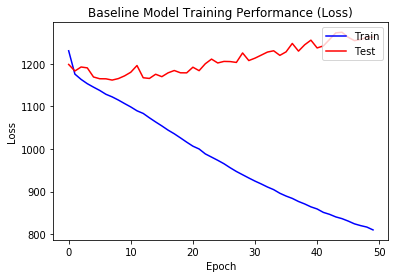

In [55]:
startTimeModule = datetime.now()

# Initialize the baseline model
reset_random(seedNum)
baseline_model_3_a = create_model_3_a()
baseline_hist_3_a = baseline_model_3_a.fit(X_train, y_train, epochs=default_epoch, batch_size=default_batch, 
                                       validation_data=(X_test, y_test), verbose=1)
print('Total time for performing cross-validation of the default model:', (datetime.now() - startTimeModule))

# Summarize model training hisotry for accuracy and loss
plt.plot(baseline_hist_3_a.history['loss'], color='blue', label='MAE - Training')
plt.plot(baseline_hist_3_a.history['val_loss'], color='red', label='MAE - Test')
plt.title('Baseline Model Training Performance (Loss)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

Train on 141238 samples, validate on 47080 samples
Epoch 1/50
141238/141238 [==============================] - 12s 85us/sample - loss: 1257.4172 - val_loss: 1202.9153
Epoch 2/50
141238/141238 [==============================] - 11s 81us/sample - loss: 1206.0028 - val_loss: 1189.4916
Epoch 3/50
141238/141238 [==============================] - 11s 81us/sample - loss: 1195.0041 - val_loss: 1206.4959
Epoch 4/50
141238/141238 [==============================] - 12s 83us/sample - loss: 1186.9300 - val_loss: 1191.4873
Epoch 5/50
141238/141238 [==============================] - 12s 83us/sample - loss: 1180.6170 - val_loss: 1174.9737
Epoch 6/50
141238/141238 [==============================] - 12s 82us/sample - loss: 1175.5962 - val_loss: 1172.0431
Epoch 7/50
141238/141238 [==============================] - 12s 82us/sample - loss: 1168.0271 - val_loss: 1168.7716
Epoch 8/50
141238/141238 [==============================] - 11s 81us/sample - loss: 1166.1428 - val_loss: 1170.5257
Epoch 9/50
141238/141

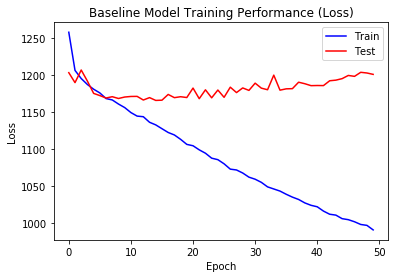

In [56]:
startTimeModule = datetime.now()

# Initialize the baseline model
reset_random(seedNum)
baseline_model_3_b = create_model_3_b()
baseline_hist_3_b = baseline_model_3_b.fit(X_train, y_train, epochs=default_epoch, batch_size=default_batch, 
                                       validation_data=(X_test, y_test), verbose=1)
print('Total time for performing cross-validation of the default model:', (datetime.now() - startTimeModule))

# Summarize model training hisotry for accuracy and loss
plt.plot(baseline_hist_3_b.history['loss'], color='blue', label='MAE - Training')
plt.plot(baseline_hist_3_b.history['val_loss'], color='red', label='MAE - Test')
plt.title('Baseline Model Training Performance (Loss)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

Train on 141238 samples, validate on 47080 samples
Epoch 1/50
141238/141238 [==============================] - 12s 85us/sample - loss: 1279.1574 - val_loss: 1206.2688
Epoch 2/50
141238/141238 [==============================] - 12s 84us/sample - loss: 1228.5109 - val_loss: 1196.1331
Epoch 3/50
141238/141238 [==============================] - 12s 85us/sample - loss: 1219.8794 - val_loss: 1196.4729
Epoch 4/50
141238/141238 [==============================] - 12s 83us/sample - loss: 1211.3577 - val_loss: 1181.3325
Epoch 5/50
141238/141238 [==============================] - 12s 84us/sample - loss: 1204.8544 - val_loss: 1174.7842
Epoch 6/50
141238/141238 [==============================] - 12s 83us/sample - loss: 1200.0468 - val_loss: 1178.2716
Epoch 7/50
141238/141238 [==============================] - 12s 85us/sample - loss: 1193.1216 - val_loss: 1170.4059
Epoch 8/50
141238/141238 [==============================] - 12s 86us/sample - loss: 1189.5208 - val_loss: 1169.9261
Epoch 9/50
141238/141

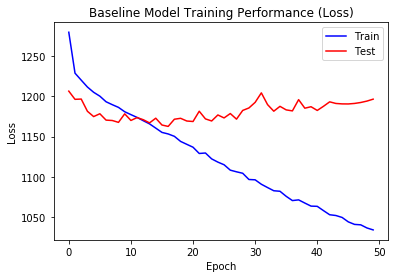

In [57]:
startTimeModule = datetime.now()

# Initialize the baseline model
reset_random(seedNum)
baseline_model_3_c = create_model_3_c()
baseline_hist_3_c = baseline_model_3_c.fit(X_train, y_train, epochs=default_epoch, batch_size=default_batch, 
                                       validation_data=(X_test, y_test), verbose=1)
print('Total time for performing cross-validation of the default model:', (datetime.now() - startTimeModule))

# Summarize model training hisotry for accuracy and loss
plt.plot(baseline_hist_3_c.history['loss'], color='blue', label='MAE - Training')
plt.plot(baseline_hist_3_c.history['val_loss'], color='red', label='MAE - Test')
plt.title('Baseline Model Training Performance (Loss)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

Train on 141238 samples, validate on 47080 samples
Epoch 1/50
141238/141238 [==============================] - 12s 86us/sample - loss: 1287.3625 - val_loss: 1206.6618
Epoch 2/50
141238/141238 [==============================] - 11s 80us/sample - loss: 1239.2542 - val_loss: 1195.4635
Epoch 3/50
141238/141238 [==============================] - 11s 81us/sample - loss: 1229.8531 - val_loss: 1188.5366
Epoch 4/50
141238/141238 [==============================] - 12s 84us/sample - loss: 1221.2875 - val_loss: 1179.5500
Epoch 5/50
141238/141238 [==============================] - 12s 82us/sample - loss: 1215.4713 - val_loss: 1175.6590
Epoch 6/50
141238/141238 [==============================] - 12s 82us/sample - loss: 1210.0917 - val_loss: 1174.7615
Epoch 7/50
141238/141238 [==============================] - 12s 84us/sample - loss: 1203.7733 - val_loss: 1173.3677
Epoch 8/50
141238/141238 [==============================] - 11s 81us/sample - loss: 1199.9889 - val_loss: 1174.6811
Epoch 9/50
141238/141

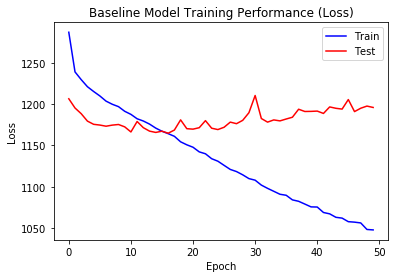

In [58]:
startTimeModule = datetime.now()

# Initialize the baseline model
reset_random(seedNum)
baseline_model_3_d = create_model_3_d()
baseline_hist_3_d = baseline_model_3_d.fit(X_train, y_train, epochs=default_epoch, batch_size=default_batch, 
                                       validation_data=(X_test, y_test), verbose=1)
print('Total time for performing cross-validation of the default model:', (datetime.now() - startTimeModule))

# Summarize model training hisotry for accuracy and loss
plt.plot(baseline_hist_3_d.history['loss'], color='blue', label='MAE - Training')
plt.plot(baseline_hist_3_d.history['val_loss'], color='red', label='MAE - Test')
plt.title('Baseline Model Training Performance (Loss)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

Train on 141238 samples, validate on 47080 samples
Epoch 1/50
141238/141238 [==============================] - 12s 86us/sample - loss: 1300.2638 - val_loss: 1211.5649
Epoch 2/50
141238/141238 [==============================] - 12s 85us/sample - loss: 1251.4400 - val_loss: 1200.9375
Epoch 3/50
141238/141238 [==============================] - 12s 84us/sample - loss: 1246.0670 - val_loss: 1196.6424
Epoch 4/50
141238/141238 [==============================] - 12s 83us/sample - loss: 1237.4417 - val_loss: 1187.9610
Epoch 5/50
141238/141238 [==============================] - 12s 85us/sample - loss: 1233.6778 - val_loss: 1184.1651
Epoch 6/50
141238/141238 [==============================] - 12s 83us/sample - loss: 1227.3888 - val_loss: 1181.3205
Epoch 7/50
141238/141238 [==============================] - 12s 83us/sample - loss: 1223.7577 - val_loss: 1179.6292
Epoch 8/50
141238/141238 [==============================] - 12s 87us/sample - loss: 1220.8119 - val_loss: 1180.4315
Epoch 9/50
141238/141

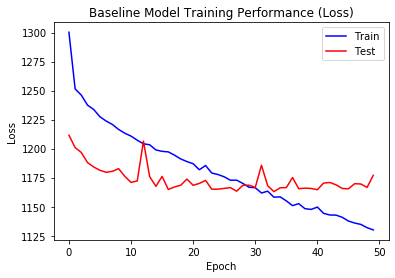

In [59]:
startTimeModule = datetime.now()

# Initialize the baseline model
reset_random(seedNum)
baseline_model_3_e = create_model_3_e()
baseline_hist_3_e = baseline_model_3_e.fit(X_train, y_train, epochs=default_epoch, batch_size=default_batch, 
                                       validation_data=(X_test, y_test), verbose=1)
print('Total time for performing cross-validation of the default model:', (datetime.now() - startTimeModule))

# Summarize model training hisotry for accuracy and loss
plt.plot(baseline_hist_3_e.history['loss'], color='blue', label='MAE - Training')
plt.plot(baseline_hist_3_e.history['val_loss'], color='red', label='MAE - Test')
plt.title('Baseline Model Training Performance (Loss)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

In [0]:
# Not applicable for this iteration of the model

In [0]:
if (notifyStatus): email_notify("Phase 5 Fit and Evaluate Model Set #3 completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

# Section 6. Fit and Evaluate Model Set #4

In [0]:
if (notifyStatus): email_notify("Phase 6 Fit and Evaluate Model Set #4 has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [0]:
# Define MLP model #4_a
def create_model_4_a():
    default_model = Sequential()
    default_model.add(Dense(1024, input_shape=(X_train.shape[1],), activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dense(512, activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dense(256, activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dense(1, kernel_initializer=default_kernel_init))
    default_model.compile(loss=default_loss, optimizer=default_optimizer)
    return default_model

In [0]:
# Define MLP model #4_b
def create_model_4_b():
    default_model = Sequential()
    default_model.add(Dense(1024, input_shape=(X_train.shape[1],), activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dropout(0.25))
    default_model.add(Dense(512, activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dropout(0.25))
    default_model.add(Dense(256, activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dropout(0.25))
    default_model.add(Dense(1, kernel_initializer=default_kernel_init))
    default_model.compile(loss=default_loss, optimizer=default_optimizer)
    return default_model

In [0]:
# Define MLP model #4_c
def create_model_4_c():
    default_model = Sequential()
    default_model.add(Dense(1024, input_shape=(X_train.shape[1],), activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dropout(0.25))
    default_model.add(Dense(512, activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dropout(0.25))
    default_model.add(Dense(256, activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dropout(0.5))
    default_model.add(Dense(1, kernel_initializer=default_kernel_init))
    default_model.compile(loss=default_loss, optimizer=default_optimizer)
    return default_model

In [0]:
# Define MLP model #4_d
def create_model_4_d():
    default_model = Sequential()
    default_model.add(Dense(1024, input_shape=(X_train.shape[1],), activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dropout(0.25))
    default_model.add(Dense(512, activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dropout(0.5))
    default_model.add(Dense(256, activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dropout(0.5))
    default_model.add(Dense(1, kernel_initializer=default_kernel_init))
    default_model.compile(loss=default_loss, optimizer=default_optimizer)
    return default_model

In [0]:
# Define MLP model #4_e
def create_model_4_e():
    default_model = Sequential()
    default_model.add(Dense(1024, input_shape=(X_train.shape[1],), activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dropout(0.5))
    default_model.add(Dense(512, activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dropout(0.5))
    default_model.add(Dense(256, activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dropout(0.5))
    default_model.add(Dense(1, kernel_initializer=default_kernel_init))
    default_model.compile(loss=default_loss, optimizer=default_optimizer)
    return default_model

Train on 141238 samples, validate on 47080 samples
Epoch 1/50
141238/141238 [==============================] - 11s 77us/sample - loss: 1224.9194 - val_loss: 1199.8944
Epoch 2/50
141238/141238 [==============================] - 11s 76us/sample - loss: 1172.5387 - val_loss: 1188.2793
Epoch 3/50
141238/141238 [==============================] - 11s 77us/sample - loss: 1157.4456 - val_loss: 1184.8728
Epoch 4/50
141238/141238 [==============================] - 11s 78us/sample - loss: 1146.3831 - val_loss: 1202.8316
Epoch 5/50
141238/141238 [==============================] - 11s 78us/sample - loss: 1136.2477 - val_loss: 1170.6004
Epoch 6/50
141238/141238 [==============================] - 11s 76us/sample - loss: 1128.2479 - val_loss: 1161.9953
Epoch 7/50
141238/141238 [==============================] - 11s 77us/sample - loss: 1115.9279 - val_loss: 1165.6520
Epoch 8/50
141238/141238 [==============================] - 11s 77us/sample - loss: 1107.0089 - val_loss: 1169.4160
Epoch 9/50
141238/141

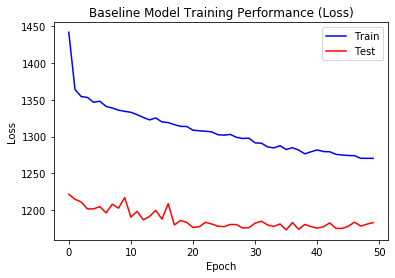

In [68]:
startTimeModule = datetime.now()

# Initialize the baseline model
reset_random(seedNum)
baseline_model_4_a = create_model_4_a()
baseline_hist_4_a = baseline_model_4_a.fit(X_train, y_train, epochs=default_epoch, batch_size=default_batch, 
                                       validation_data=(X_test, y_test), verbose=1)
print('Total time for performing cross-validation of the default model:', (datetime.now() - startTimeModule))

# Summarize model training hisotry for accuracy and loss
plt.plot(baseline_hist_1_d.history['loss'], color='blue', label='MAE - Training')
plt.plot(baseline_hist_1_d.history['val_loss'], color='red', label='MAE - Test')
plt.title('Baseline Model Training Performance (Loss)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

Train on 141238 samples, validate on 47080 samples
Epoch 1/50
141238/141238 [==============================] - 12s 85us/sample - loss: 1242.4044 - val_loss: 1194.3679
Epoch 2/50
141238/141238 [==============================] - 12s 83us/sample - loss: 1193.0322 - val_loss: 1183.0274
Epoch 3/50
141238/141238 [==============================] - 12s 83us/sample - loss: 1182.5753 - val_loss: 1190.3113
Epoch 4/50
141238/141238 [==============================] - 11s 80us/sample - loss: 1173.5130 - val_loss: 1192.7712
Epoch 5/50
141238/141238 [==============================] - 12s 82us/sample - loss: 1167.3643 - val_loss: 1167.0726
Epoch 6/50
141238/141238 [==============================] - 12s 82us/sample - loss: 1159.0248 - val_loss: 1166.0076
Epoch 7/50
141238/141238 [==============================] - 12s 82us/sample - loss: 1151.9341 - val_loss: 1165.1118
Epoch 8/50
141238/141238 [==============================] - 12s 82us/sample - loss: 1148.1541 - val_loss: 1163.0414
Epoch 9/50
141238/141

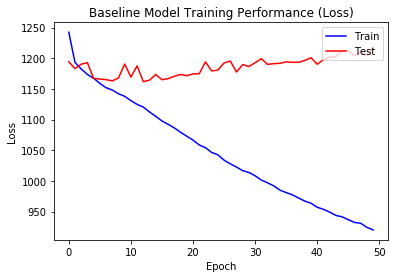

In [69]:
startTimeModule = datetime.now()

# Initialize the baseline model
reset_random(seedNum)
baseline_model_4_b = create_model_4_b()
baseline_hist_4_b = baseline_model_4_b.fit(X_train, y_train, epochs=default_epoch, batch_size=default_batch, 
                                       validation_data=(X_test, y_test), verbose=1)
print('Total time for performing cross-validation of the default model:', (datetime.now() - startTimeModule))

# Summarize model training hisotry for accuracy and loss
plt.plot(baseline_hist_4_b.history['loss'], color='blue', label='MAE - Training')
plt.plot(baseline_hist_4_b.history['val_loss'], color='red', label='MAE - Test')
plt.title('Baseline Model Training Performance (Loss)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

Train on 141238 samples, validate on 47080 samples
Epoch 1/50
141238/141238 [==============================] - 12s 85us/sample - loss: 1255.3174 - val_loss: 1199.1809
Epoch 2/50
141238/141238 [==============================] - 12s 85us/sample - loss: 1205.4935 - val_loss: 1181.9244
Epoch 3/50
141238/141238 [==============================] - 11s 81us/sample - loss: 1197.5131 - val_loss: 1190.3327
Epoch 4/50
141238/141238 [==============================] - 12s 82us/sample - loss: 1187.3555 - val_loss: 1184.7671
Epoch 5/50
141238/141238 [==============================] - 11s 80us/sample - loss: 1179.3972 - val_loss: 1170.7780
Epoch 6/50
141238/141238 [==============================] - 12s 84us/sample - loss: 1172.9300 - val_loss: 1166.2462
Epoch 7/50
141238/141238 [==============================] - 12s 83us/sample - loss: 1165.5014 - val_loss: 1166.6819
Epoch 8/50
141238/141238 [==============================] - 11s 81us/sample - loss: 1161.8644 - val_loss: 1164.2409
Epoch 9/50
141238/141

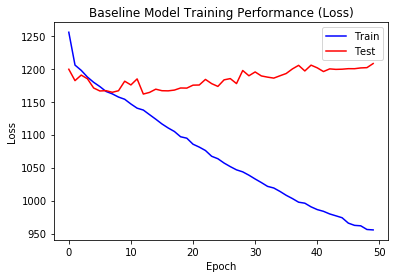

In [70]:
startTimeModule = datetime.now()

# Initialize the baseline model
reset_random(seedNum)
baseline_model_4_c = create_model_4_c()
baseline_hist_4_c = baseline_model_4_c.fit(X_train, y_train, epochs=default_epoch, batch_size=default_batch, 
                                       validation_data=(X_test, y_test), verbose=1)
print('Total time for performing cross-validation of the default model:', (datetime.now() - startTimeModule))

# Summarize model training hisotry for accuracy and loss
plt.plot(baseline_hist_4_c.history['loss'], color='blue', label='MAE - Training')
plt.plot(baseline_hist_4_c.history['val_loss'], color='red', label='MAE - Test')
plt.title('Baseline Model Training Performance (Loss)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

Train on 141238 samples, validate on 47080 samples
Epoch 1/50
141238/141238 [==============================] - 12s 86us/sample - loss: 1263.3362 - val_loss: 1212.0316
Epoch 2/50
141238/141238 [==============================] - 11s 81us/sample - loss: 1214.8741 - val_loss: 1187.5035
Epoch 3/50
141238/141238 [==============================] - 12s 81us/sample - loss: 1206.1891 - val_loss: 1212.8198
Epoch 4/50
141238/141238 [==============================] - 12s 82us/sample - loss: 1194.3597 - val_loss: 1185.5530
Epoch 5/50
141238/141238 [==============================] - 12s 82us/sample - loss: 1185.7923 - val_loss: 1170.6579
Epoch 6/50
141238/141238 [==============================] - 11s 80us/sample - loss: 1179.5639 - val_loss: 1165.4626
Epoch 7/50
141238/141238 [==============================] - 12s 83us/sample - loss: 1172.4521 - val_loss: 1164.2144
Epoch 8/50
141238/141238 [==============================] - 12s 84us/sample - loss: 1169.0554 - val_loss: 1162.2191
Epoch 9/50
141238/141

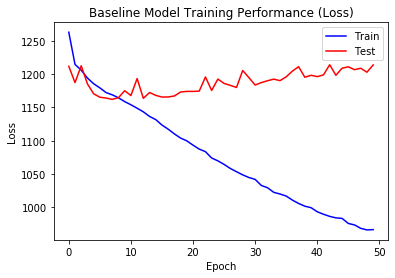

In [71]:
startTimeModule = datetime.now()

# Initialize the baseline model
reset_random(seedNum)
baseline_model_4_d = create_model_4_d()
baseline_hist_4_d = baseline_model_4_d.fit(X_train, y_train, epochs=default_epoch, batch_size=default_batch, 
                                       validation_data=(X_test, y_test), verbose=1)
print('Total time for performing cross-validation of the default model:', (datetime.now() - startTimeModule))

# Summarize model training hisotry for accuracy and loss
plt.plot(baseline_hist_4_d.history['loss'], color='blue', label='MAE - Training')
plt.plot(baseline_hist_4_d.history['val_loss'], color='red', label='MAE - Test')
plt.title('Baseline Model Training Performance (Loss)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

Train on 141238 samples, validate on 47080 samples
Epoch 1/50
141238/141238 [==============================] - 12s 83us/sample - loss: 1276.4187 - val_loss: 1209.2909
Epoch 2/50
141238/141238 [==============================] - 12s 82us/sample - loss: 1227.4981 - val_loss: 1190.9409
Epoch 3/50
141238/141238 [==============================] - 11s 81us/sample - loss: 1220.2237 - val_loss: 1194.7000
Epoch 4/50
141238/141238 [==============================] - 12s 82us/sample - loss: 1211.1539 - val_loss: 1179.0833
Epoch 5/50
141238/141238 [==============================] - 11s 80us/sample - loss: 1203.7382 - val_loss: 1181.1841
Epoch 6/50
141238/141238 [==============================] - 11s 80us/sample - loss: 1199.8925 - val_loss: 1172.6194
Epoch 7/50
141238/141238 [==============================] - 12s 82us/sample - loss: 1194.7586 - val_loss: 1169.6265
Epoch 8/50
141238/141238 [==============================] - 12s 84us/sample - loss: 1192.3971 - val_loss: 1169.3688
Epoch 9/50
141238/141

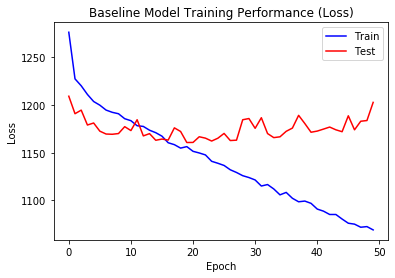

In [72]:
startTimeModule = datetime.now()

# Initialize the baseline model
reset_random(seedNum)
baseline_model_4_e = create_model_4_e()
baseline_hist_4_e = baseline_model_4_e.fit(X_train, y_train, epochs=default_epoch, batch_size=default_batch, 
                                       validation_data=(X_test, y_test), verbose=1)
print('Total time for performing cross-validation of the default model:', (datetime.now() - startTimeModule))

# Summarize model training hisotry for accuracy and loss
plt.plot(baseline_hist_4_e.history['loss'], color='blue', label='MAE - Training')
plt.plot(baseline_hist_4_e.history['val_loss'], color='red', label='MAE - Test')
plt.title('Baseline Model Training Performance (Loss)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

In [0]:
if (notifyStatus): email_notify("Phase 6 Fit and Evaluate Model Set #4 completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [74]:
print ('Total time for the script:',(datetime.now() - startTimeScript))

Total time for the script: 3:12:54.421773
